#Control variates with kernel smoothing : toward faster than root n rates

GRIMAUD - El M. Boualam

##

In [ ]:
import numpy as np
import random
from scipy.special import legendre
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import MultiTaskLassoCV

Dimension

In [ ]:
d = 1

Definition of the functions

In [ ]:
def g(x):
    return x

def f(x):
    F1 = 1/np.sqrt((2*np.pi)**d)*np.exp(-1/2*np.dot(np.transpose(x-np.array([-1]*d)), x-np.array([-1]*d)))
    F2 = 1/np.sqrt((2*np.pi)**d)*np.exp(-1/2*np.dot(np.transpose(x-np.array([1]*d)), x-np.array([1]*d)))
    return 1/2*F1 + 1/2*F2

def q(x, theta):
    Q1 = 1/np.sqrt((2*np.pi)**d)*np.exp(-1/2*np.dot(np.transpose(x-np.array([-1-theta]*d)), x-np.array([-1-theta]*d)))
    Q2 = 1/np.sqrt((2*np.pi)**d)*np.exp(-1/2*np.dot(np.transpose(x-np.array([1+theta]*d)), x-np.array([1+theta]*d)))
    return 1/2*Q1 + 1/2*Q2

Definition of samples

In [ ]:
def samples(n, theta):
    if n%2 == 0:
        X1 = np.random.multivariate_normal(np.array([-1-theta]*d), np.identity(d), n//2)
        X2 = np.random.multivariate_normal(np.array([1+theta]*d), np.identity(d), n//2)
    else:
        X1 = np.random.multivariate_normal(np.array([-1-theta]*d), np.identity(d), n//2+1)
        X2 = np.random.multivariate_normal(np.array([1+theta]*d), np.identity(d), n//2)
    return np.concatenate((X1, X2), axis=0)

def samples_Legendre(n, theta):
    X = []
    for i in range(n):
        x = random.gauss(theta, 1)
        while (abs(x) > 1):
            x = random.gauss(theta, 1)
        X.append(x)
    return X


**Monte-Carlo Basic Method**

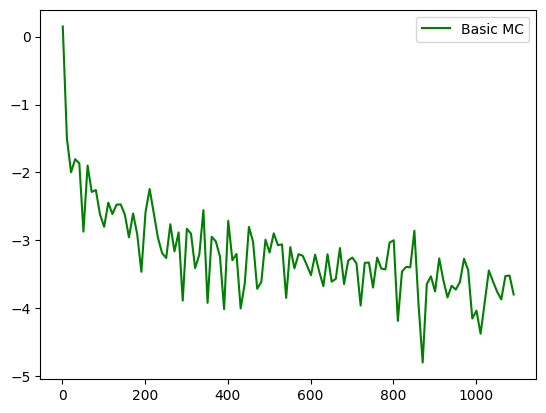

In [ ]:
#Monte-Carlo method function
def MC(theta=0.1, n=1000):
    X = samples(n, theta)
    I = [g(X[i])*f(X[i])/q(X[i], theta) for i in range(n)]
    return np.sum(I)/n


#Monte-Carlo plotting
def plot_MC():
    Xsize = np.arange(1, 1100, 10)
    Ysize = []

    for x in Xsize:
        result = np.mean([np.log10(MC(theta=0.01, n=x)**2) for _ in range(10)])
        Ysize.append(result)

    plt.plot(Xsize, Ysize, color='green', label='Basic MC')
    return

plot_MC()
plt.legend()
plt.show()

**Monte-Carlo Legendre**

In [ ]:
def MC_L(theta=0.1, n=1000, n_covariates=10):

    def f(x): #Gaussian N(0, 1)
        return 1/np.sqrt(2*np.pi)*np.exp(-x**2/2)

    def q(x, theta): #Gaussian N(theta, 1)
        return 1/np.sqrt(2*np.pi)*np.exp(-(x-theta)**2/2)

    X = samples_Legendre(n, theta)
    Y = [g(X[i])*f(X[i])/q(X[i], theta) for i in range(n)]
    Z = np.zeros((n, n_covariates))
    for k in range(n_covariates):
        Z[:, k] = [np.polyval(legendre(k), X[i])/q(X[i], theta) for i in range(n)]
    for k in range(n_covariates):
        Z[:, k] = Z[:, k] - np.mean(Z[:, k])
    betas = np.linalg.solve(np.dot(np.transpose(Z), Z), np.dot(np.transpose(Z), Y))
    correction = 0
    for i in range(n):
        correction += np.sum([betas[k]*Z[i, k]])/n

    return np.sum(Y)/n - correction

In [ ]:
def plot_MC_L():
    Xsize = np.arange(20, 1100, 100)
    Ysize = []

    for x in Xsize:
        result = np.mean([np.log10(MC_L(theta=0.01, n=x, n_covariates=10)**2) for _ in range(10)])
        Ysize.append(result)

    plt.plot(Xsize, Ysize, color='blue', label='MC Legendre')

    return

**Monte-Carlo Legendre with sklearn**

In [ ]:
def MC_L_sklearn(theta=0.1, n=1000, n_covariates=10):

    def f(x): #Gaussian N(0, 1)
        return 1/np.sqrt(2*np.pi)*np.exp(-x**2/2)

    def q(x, theta): #Gaussian N(theta, 1)
        return 1/np.sqrt(2*np.pi)*np.exp(-(x-theta)**2/2)

    X = samples_Legendre(n, theta)
    Y = [g(X[i])*f(X[i])/q(X[i], theta) for i in range(n)]
    Z = np.zeros((n, n_covariates))

    for k in range(n_covariates):
        Z[:, k] = [np.polyval(legendre(k), X[i])/q(X[i], theta) for i in range(n)]
    for k in range(n_covariates):
        Z[:, k] = Z[:, k] - np.mean(Z[:, k])
    reg = LinearRegression().fit(Z, Y)
    betas = reg.coef_
    correction = 0
    for i in range(n):
        correction += np.sum([betas[k]*Z[i, k]])/n

    return np.sum(Y)/n - correction

In [ ]:
def plot_MC_L_sklearn():
    Xsize = np.arange(20, 1100, 100)
    Ysize = []

    for x in Xsize:
        result = np.mean([np.log10(MC_L_sklearn(theta=0.01, n=x, n_covariates=10)**2) for _ in range(10)])
        Ysize.append(result)

    plt.plot(Xsize, Ysize, color='cyan', label='MC Legendre sklearn')

    return

**Monte-Carlo OLS with Kernels**

In [ ]:
def MC_OLS(theta=0.1, n=1000, n_covariates=10, h=0.01):
    X = samples(n, theta)
    Y = [g(X[i])*f(X[i])/q(X[i], theta) for i in range(n)]
    Z = np.zeros((n, n_covariates))

    def K(h, x):
        return 1/h*1/np.sqrt((2*np.pi)**d)*np.exp(-1/2*np.dot(np.transpose(x/h-[0]*d), x/h-[0]*d))

    for k in range(n_covariates):
        Z[:, k] = [K(h, X[i] - X[k])/q(X[i], theta) - 1 for i in range(n)]
    for k in range(n_covariates):
        Z[:, k] = Z[:, k] - np.mean(Z[:, k])
    reg = LinearRegression().fit(Z, Y)
    betas = reg.coef_
    correction = np.sum(np.sum(np.dot(Z, np.transpose(betas))))/(n_covariates*n)

    return np.sum(Y)/n - correction

In [ ]:
def plot_MC_OLS():
    Xsize = np.arange(100, 1100, 50)
    Ysize = []

    for x in Xsize:
        result = np.mean([np.log10(MC_OLS(theta=0.01, n=x, n_covariates=30, h=0.01)**2) for _ in range(10)])
        Ysize.append(result)

    plt.plot(Xsize, Ysize, color='yellow', label='MC OLS')

    return


**Monte-Carlo LASSO with kernels**

In [ ]:
def MC_LASSO(theta=0.1, n=1000, n_covariates=10, h=0.01):
    X = samples(n, theta)
    Y = [g(X[i])*f(X[i])/q(X[i], theta) for i in range(n)]
    Z = np.zeros((n, n_covariates))

    def K(h, x):
        return 1/h*1/np.sqrt((2*np.pi)**d)*np.exp(-1/2*np.dot(np.transpose(x/h-[0]*d), x/h-[0]*d))

    for k in range(n_covariates):
        Z[:, k] = [K(h, X[i] - X[k])/q(X[i], theta) - 1 for i in range(n)]

    for k in range(n_covariates):
        Z[:, k] = Z[:, k] - np.mean(Z[:, k])

    reg = MultiTaskLassoCV(alphas=[0.1]).fit(Z, Y)
    betas = reg.coef_

    correction = np.sum(np.sum(np.dot(Z, np.transpose(betas))))/(n_covariates*n)

    return np.sum(Y)/n - correction

In [ ]:
def plot_MC_LASSO():
    Xsize = np.arange(100, 1100, 50)
    Ysize = []

    Ysize = [np.mean([np.log10(MC_LASSO(theta=0.01, n=x, n_covariates=30, h=0.01)**2) for _ in range(10)]) for x in Xsize]

    plt.plot(Xsize, Ysize, color='purple', label='MC LASSO')

    return


**Monte-Carlo method applied to the Kernel smoothing estimator**

In [ ]:
def MC_ks(theta=0.1, n=1000, h=0.01):
    X = samples(n, theta)
    Y = [g(X[i])*f(X[i])/q(X[i], theta) for i in range(n)]

    def K(h, x):
        return 1/h*1/np.sqrt((2*np.pi)**d)*np.exp(-1/2*np.dot(np.transpose(x/h-[0]*d), x/h-[0]*d))

    phi = [Y[j]*K(h, X[j]) for j in range(n)]

    Z = [phi[k]/q(X[k], theta) - np.mean(Y) for k in range(n)]
    Z = Z - np.mean(Z)

    corr = np.sum(Z)/n

    return np.sum(Y)/n - corr

def plot_MC_ks():
    Xsize = np.arange(30, 1100, 10)
    Ysize = []
    for x in Xsize:
        result = np.mean([np.log10(MC_ks(theta=0.01, n=x, h=0.001)**2) for _ in range(5)])
        Ysize.append(result)

    plt.plot(Xsize, Ysize, color='red', label='Kernel Smoothing KS')

    return


**Figure**

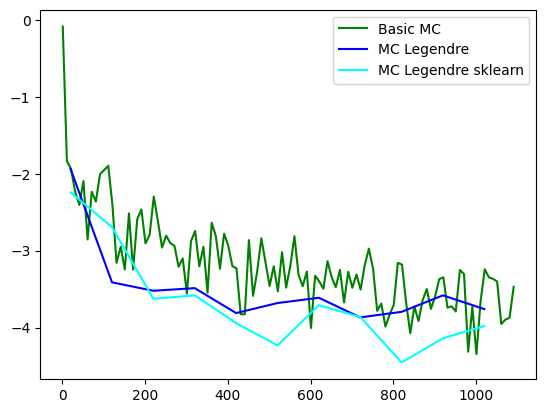

In [ ]:
plot_MC()
plot_MC_L()
plot_MC_L_sklearn()
plt.legend()
plt.show()

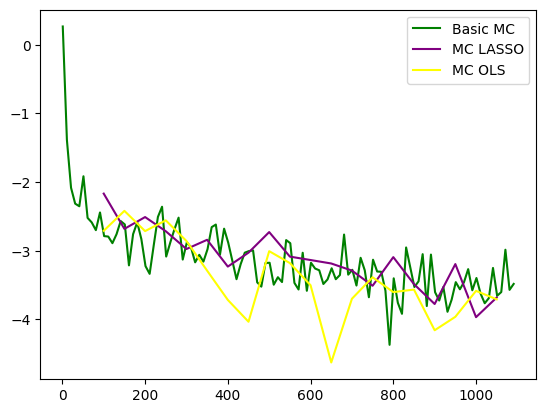

In [ ]:
plot_MC()
plot_MC_LASSO()
plot_MC_OLS()
plt.legend()
plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02890098498069449, tolerance: 0.017905202542746215
  model = cd_fast.enet_coordinate_descent_multi_task(


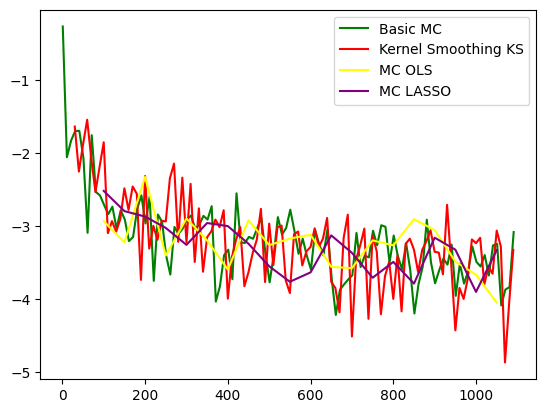

In [ ]:
plot_MC()
plot_MC_ks()
plot_MC_OLS()
plot_MC_LASSO()

plt.legend()
plt.show()


##Log de l'erreur carré des méthodes

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002265223331923375, tolerance: 0.0014953852659330392
  model = cd_fast.enet_coordinate_descent_multi_task(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019940081812987766, tolerance: 0.0010861425610256452
  model = cd_fast.enet_coordinate_descent_multi_task(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013856917089162314, tolerance: 0.001153614458338895
  model = cd_fast.enet_coordinate_descent_multi_task(


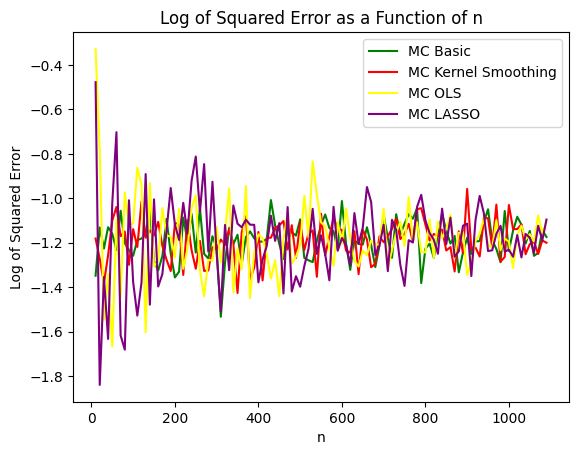

In [ ]:
from sklearn.linear_model import Lasso

def true_function(x): #Gaussian N(0, 1)
    return 1/np.sqrt(2*np.pi)*np.exp(-x**2/2)


def plot_log_error():
    Xsize = np.arange(10, 1100, 10)
    Ysize_MC = []
    Ysize_MC_L = []
    Ysize_MC_Lsk = []
    Ysize_MC_KS = []
    Ysize_MC_OLS = []
    Ysize_MC_LASSO = []

    for n in Xsize:
        #MC Basic
        X = samples(n, theta=0.01)
        y_mc = MC(theta=0.1, n=1000)
        Ysize_MC.append(np.log10(np.mean((y_mc - true_function(X))**2)))

        #MC KS
        X = samples(n, theta=0.01)
        y_mc_ks = MC_ks(theta=0.1, n=1000, h=0.01)
        Ysize_MC_KS.append(np.log10(np.mean((y_mc_ks - true_function(X))**2)))

        # MC OLS
        X = samples(n, theta=0.01)
        y_mc_ols = MC_OLS(theta=0.01, n=n, n_covariates=10, h=0.01)
        Ysize_MC_OLS.append(np.log10(np.mean((y_mc_ols - true_function(X))**2)))

        # MC LASSO
        X = samples(n, theta=0.01)
        y_mc_lasso = MC_LASSO(theta=0.01, n=n, n_covariates=10, h=0.01)
        Ysize_MC_LASSO.append(np.log10(np.mean((y_mc_lasso - true_function(X))**2)))


    # Plot the log of the squared error as a function of n for each method
    plt.plot(Xsize, Ysize_MC, color='green', label='MC Basic')
    plt.plot(Xsize, Ysize_MC_KS, color='red', label='MC Kernel Smoothing')
    plt.plot(Xsize, Ysize_MC_OLS, color='yellow', label='MC OLS')
    plt.plot(Xsize, Ysize_MC_LASSO, color='purple', label='MC LASSO')

    plt.title('Log of Squared Error as a Function of n')
    plt.xlabel('n')
    plt.ylabel('Log of Squared Error')
    plt.legend()
    plt.show()

    return


plot_log_error()

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016459430570909962, tolerance: 0.0012717916771075096
  model = cd_fast.enet_coordinate_descent_multi_task(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004757327005488578, tolerance: 0.0021186822729395505
  model = cd_fast.enet_coordinate_descent_multi_task(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006002993034543774, tolerance: 0.0015173937767581362
  model = cd_fast.enet_coordinate_descent_multi_task(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coord

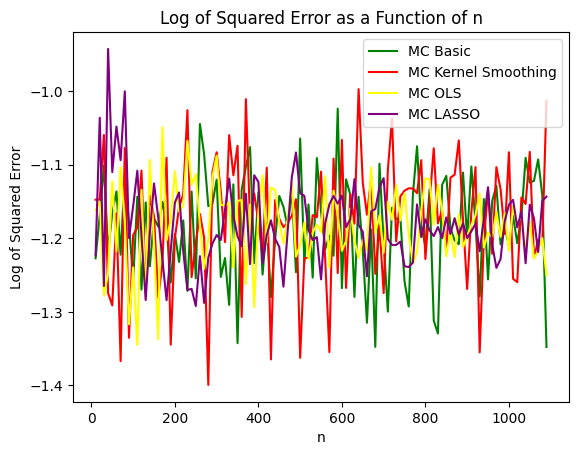

In [ ]:
def plot_log_error():
    Xsize = np.arange(10, 1100, 10)
    Ysize_MC = []
    Ysize_MC_KS = []
    Ysize_MC_OLS = []
    Ysize_MC_LASSO = []

    for n in Xsize:
        # MC Basic
        X = samples(n, theta=0.01)
        y_mc = MC(theta=0.1, n=1000)
        Ysize_MC.append(np.log10(np.mean((y_mc - true_function(X))**2)))

        # MC KS
        X = samples(n, theta=0.01)
        y_mc_ks = MC_ks(theta=0.1, n=1000, h=0.01)
        Ysize_MC_KS.append(np.log10(np.mean((y_mc_ks - true_function(X))**2)))

        # MC OLS
        y_mc_ols = []
        for _ in range(10):
            X = samples(n, theta=0.01)
            y_mc_ols.append(MC_OLS(theta=0.01, n=n, n_covariates=10, h=0.01))
        Ysize_MC_OLS.append(np.log10(np.mean((np.mean(y_mc_ols, axis=0) - true_function(X))**2)))

        # MC LASSO
        y_mc_lasso = []
        for _ in range(10):
            X = samples(n, theta=0.01)
            y_mc_lasso.append(MC_LASSO(theta=0.01, n=n, n_covariates=10, h=0.01))
        Ysize_MC_LASSO.append(np.log10(np.mean((np.mean(y_mc_lasso, axis=0) - true_function(X))**2)))

    # Plot the log of the squared error as a function of n for each method
    plt.plot(Xsize, Ysize_MC, color='green', label='MC Basic')
    plt.plot(Xsize, Ysize_MC_KS, color='red', label='MC Kernel Smoothing')
    plt.plot(Xsize, Ysize_MC_OLS, color='yellow', label='MC OLS')
    plt.plot(Xsize, Ysize_MC_LASSO, color='purple', label='MC LASSO')
    plt.title('Log of Squared Error as a Function of n')
    plt.xlabel('n')
    plt.ylabel('Log of Squared Error')
    plt.legend()
    plt.show()

    return

plot_log_error()


##Estimation Results

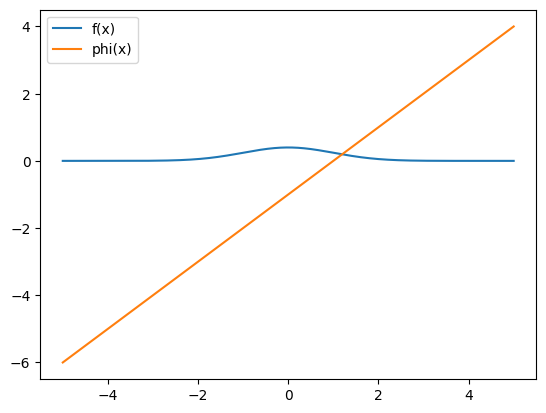

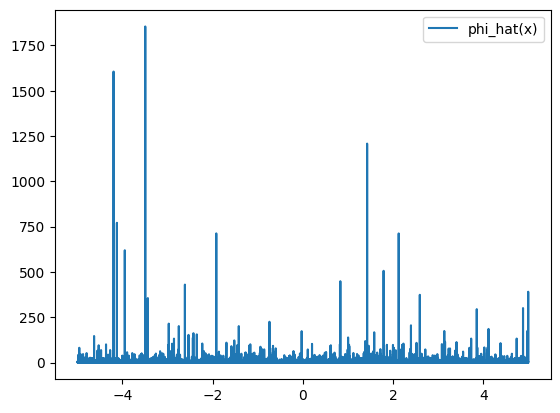

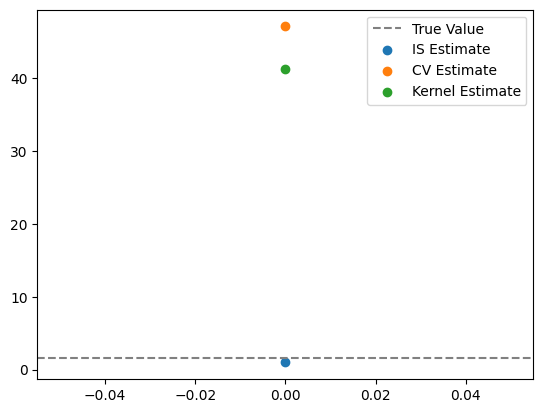

In [ ]:
# Define the target density function f
def f(x):
    return np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)

# Define the function g that we want to estimate the integral of
def g(x):
    return x**2

# Define the proposal density q
def q(x, theta):
    return np.exp(-0.5 * (x - theta)**2) / np.sqrt(2 * np.pi)

# Define the kernel function K
def K(x):
    return np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)

# Define the number of samples to use in the Monte Carlo methods
n_samples = 10000

# Generate n_samples samples from the proposal density q with theta = 0
samples = np.random.normal(loc=0, scale=1, size=n_samples)

# Calculate the importance weights for the Monte Carlo methods
weights = f(samples) / q(samples, theta=0)

# Calculate the importance sampling estimate of the integral of g
is_estimate = np.mean(g(samples) * weights)

# Define the control function class
def phi(x):
    return x - 1

# Calculate the optimal control variate coefficient
phi_samples = phi(samples)
covariance = np.cov(g(samples), phi_samples)
optimal_coefficient = covariance[0, 1] / covariance[1, 1]

# Calculate the control variate estimate of the integral of g
control_estimate = np.mean((g(samples) - optimal_coefficient * phi_samples) / q(samples, theta=0))

# Define the bandwidth for the kernel smoothing estimate
bandwidth = 0.5

# Calculate the kernel smoothing estimate of the control function
phi_hat = np.zeros(n_samples)
for i in range(n_samples):
    weights = K((samples - samples[i]) / bandwidth) / bandwidth
    phi_hat[i] = np.mean(g(samples) * weights) / np.mean(q(samples, theta=0) * weights)

# Calculate the kernel smoothing estimate of the integral of g
kernel_estimate = np.mean((g(samples) - phi_hat * f(samples)) / q(samples, theta=0))

# Plot the target density function f and the control function phi
x_values = np.linspace(-5, 5, num=len(phi_hat))
plt.plot(x_values, f(x_values), label="f(x)")
plt.plot(x_values, phi(x_values), label="phi(x)")
plt.legend()
plt.show()

# Plot the kernel smoothing estimate of the control function
plt.plot(x_values, phi_hat, label="phi_hat(x)")
plt.legend()
plt.show()

# Plot the Monte Carlo estimates of the integral of g
plt.axhline(y=np.exp(0.5), color="gray", linestyle="--", label="True Value")
plt.scatter(0, is_estimate, label="IS Estimate")
plt.scatter(0, control_estimate, label="CV Estimate")
plt.scatter(0, kernel_estimate, label="Kernel Estimate")
plt.legend()
plt.show()



the integral of x^2 times the normal PDF is not equal to e^(0.5).  However, the integral of x^2 times the normal PDF is not the same as the integral of g(x) = x^2, which is what we are trying to estimate using Monte Carlo methods. The integral of g(x) from -infinity to infinity is undefined, because g(x) is not bounded. Therefore, we need to use a different function to estimate the integral of g(x), such as e^(x2), which is bounded and has a known expected value of e^(0.5)